# Training Notebook

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from NMPC_Net.dataset import dataset
from NMPC_Net.controller import utils
from NMPC_Net.controller.MPC import MPC, MPCParams
from NMPC_Net.simulation import simulation
from sklearn import preprocessing
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10, 10]

2022-04-27 12:36:07.570564: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-27 12:36:07.570585: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [ ]:
X_raw,y = dataset.Dataset.load('data/data5-400000.csv')

In [ ]:
#scaler = preprocessing.StandardScaler().fit(X_raw)
#X = scaler.transform(X_raw)
X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.20, random_state=42)

In [ ]:
normalizationLayer = tf.keras.layers.Normalization(axis=-1, input_dim=5)
normalizationLayer.adapt(X_train)

In [ ]:
batch_size, lr, num_epochs = 5000, 0.001, 800
loss = tf.keras.losses.MeanSquaredError()
trainer = tf.keras.optimizers.Adam(learning_rate=lr)

In [ ]:
net = tf.keras.models.Sequential([
    normalizationLayer,
    tf.keras.layers.Dense(64, activation='relu'),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(2)
])
net.summary()

In [ ]:
net.compile(trainer, loss)
net.fit(
    x = X_train,
    y = y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=0.1,
    use_multiprocessing=True)

In [ ]:
net.evaluate(x=X_test, y=y_test)

In [ ]:
net.save('model-temp1.hdf5')

In [4]:
loaded_model = tf.keras.models.load_model('model-temp1.hdf5')
def nnController(initialState, finalState):
    relativeInitial, relativeFinal = utils.absoluteToRelative(initialState, finalState)
    inputVector = tf.constant([
        relativeInitial[0],
        relativeFinal[0],
        relativeFinal[1],
        relativeFinal[2],
        relativeFinal[3]
    ], shape=(1,5))
    #normalizedInput = scaler.transform(inputVector)
    predictedControl = loaded_model.predict(inputVector)
    return np.array([predictedControl[0][0], predictedControl[0][1]], dtype=np.double)

params = MPCParams()
params.H = 10 # seconds
mpcController = MPC(params=params)

ds = dataset.Dataset()

def compare(initialState, targetState):
    sims = []
    simNN = simulation.Simulation(
        initialState,
        targetState,
        10.0,
        nnController,
        stop_r=1.0)
    simMPC = simulation.Simulation(
        initialState,
        targetState,
        10.0,
        mpcController,
        stop_r=1.0)
    sims.append(simNN)
    sims.append(simMPC)

    print("Neural Net Simulation")
    simNN.run_simulation(20.0)
    print()
    print("MPC Simulation")
    simMPC.run_simulation(20.0)
    print()
    
    print(f"Initial State: {initialState.flatten()}")
    print(f"Target State: {targetState.flatten()}")
    print(f"Normalized IAE: {simulation.iae(sim1=simNN, sim2=simMPC)}")
    print(f"MPC Average Execution Time (s): {simMPC.avgExecutionTime}")
    print(f"NN Average Execution Time (s): {simNN.avgExecutionTime}")
    
    simulation.plot_paths(sims=sims, labels=["Neural Net", "MPC"])
    simulation.plot_inputs(sims=sims, labels=["Neural Net", "MPC"])

Neural Net Simulation
68: Sim time: 6.799999999999992/20.0                        Wall Time: 0:00:02.0551979
MPC Simulation
88: Sim time: 8.799999999999985/20.0                        Wall Time: 0:00:10.1205348
Initial State: [0.         0.         5.27373871 0.        ]
Target State: [51.67754911 -6.87727954  0.         -1.18564827]
Normalized IAE: 2.2198490084151272
MPC Average Execution Time (s): 0.11447817977528091
NN Average Execution Time (s): 0.02979742028985508


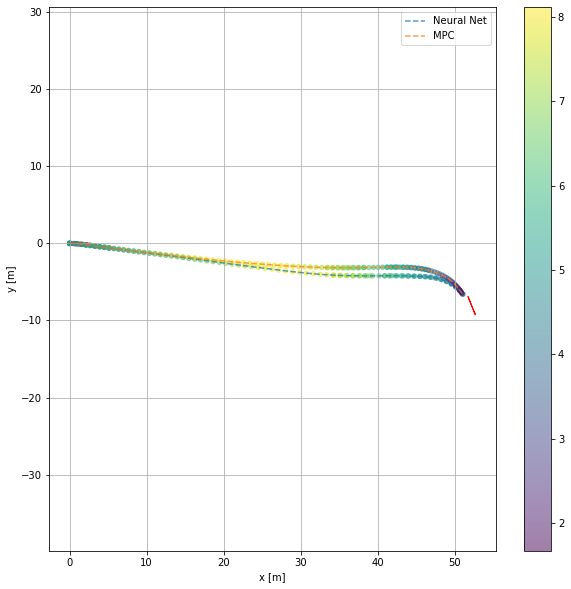

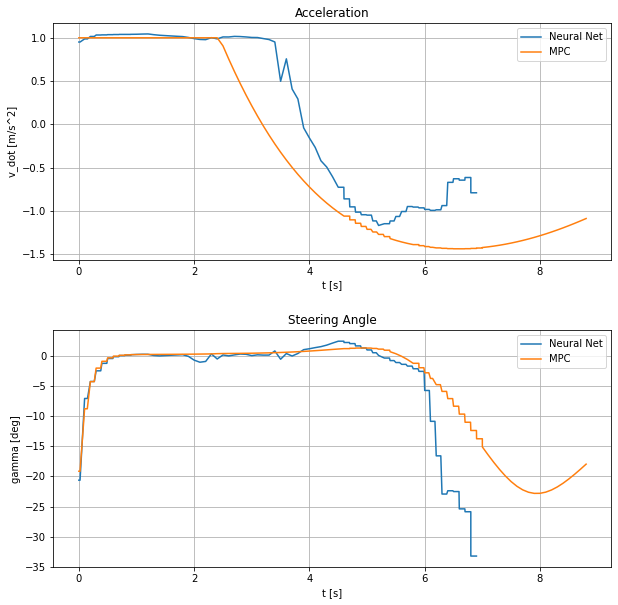

In [7]:
initialState = ds._get_rand_x0()
targetState = ds._get_rand_xf()
compare(initialState, targetState)

Neural Net Simulation
101: Sim time: 10.09999999999998/20.0                        Wall Time: 0:00:03.111344
MPC Simulation
104: Sim time: 10.399999999999979/20.0                        Wall Time: 0:00:11.752154
Initial State: [0.         0.         3.25779867 0.        ]
Target State: [48.40064738 21.00526021  0.          0.70573952]
Normalized IAE: 0.1982828697194853
MPC Average Execution Time (s): 0.11250578095238094
NN Average Execution Time (s): 0.030397499999999994


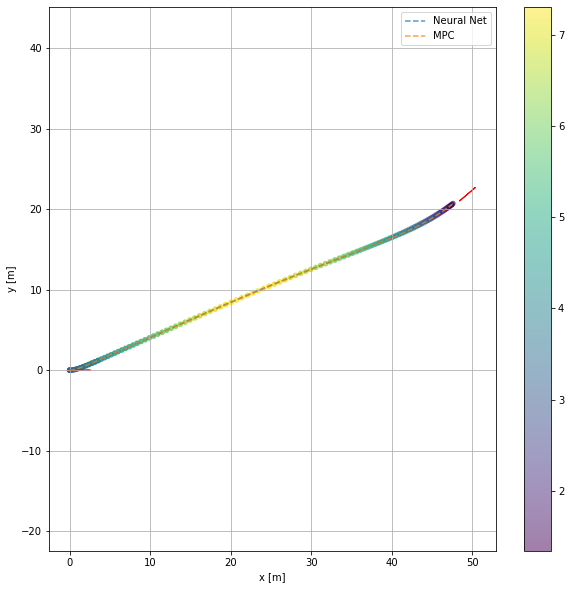

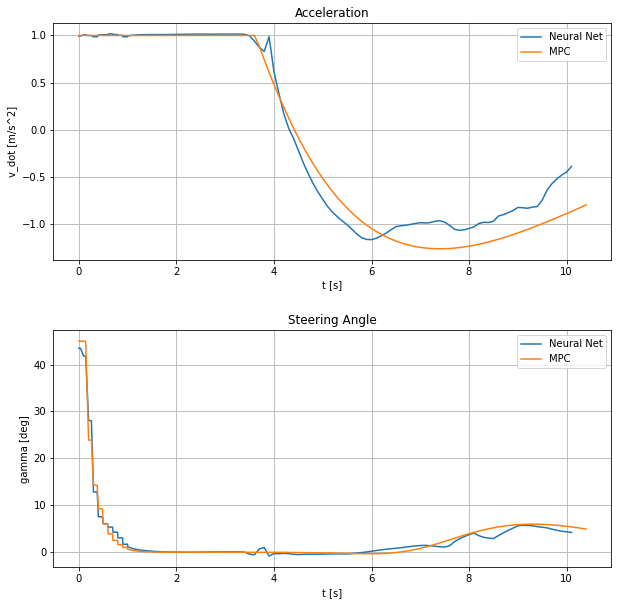

In [6]:
initialState = ds._get_rand_x0()
targetState = ds._get_rand_xf()
compare(initialState, targetState)

Neural Net Simulation
80: Sim time: 7.999999999999988/20.0                        Wall Time: 0:00:02.4482251
MPC Simulation
99: Sim time: 9.89999999999998/20.0                        Wall Time: 0:00:12.69694396
Initial State: [0.         0.         4.67653903 0.        ]
Target State: [ 50.10180076 -29.6760925    0.          -1.15247386]
Normalized IAE: 1.8550772935633808
MPC Average Execution Time (s): 0.12761719999999996
NN Average Execution Time (s): 0.030208691358024696


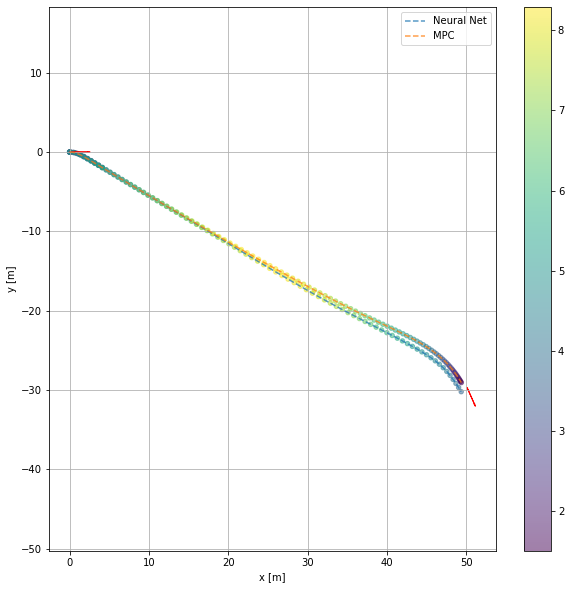

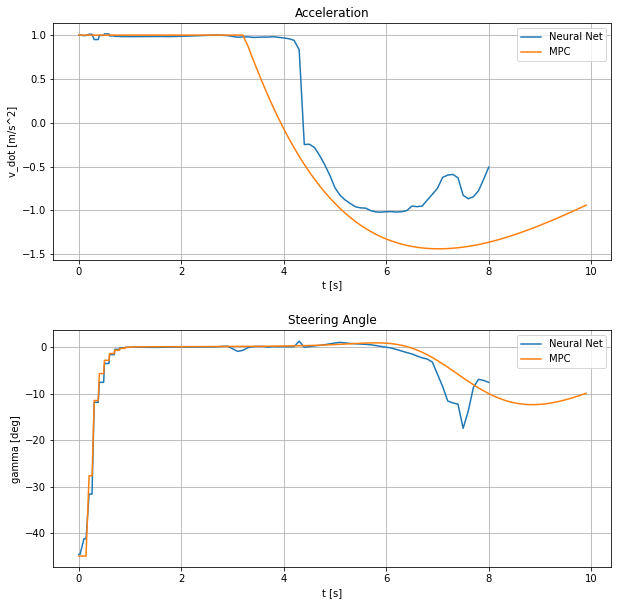

In [9]:
initialState = ds._get_rand_x0()
targetState = ds._get_rand_xf()
compare(initialState, targetState)